### **ICL Graduate Assignment 1 - Paper Results Reproduce**
##### **Paper Reference**: [Communication-Efficient Learning of Deep Networks from Decentralized Data](https://arxiv.org/pdf/1602.05629.pdf)
##### **Code by**: Bahy Helmi Hartoyo Putra (bahyhelmi97@gmail.com)

In [1]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm import tqdm
from time import time
from sklearn import utils
from sklearn.metrics import accuracy_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [2]:
tf.compat.v1.logging.set_verbosity(40) # ERROR

#### Task 2 - Reproduce Table [1]
- **Dataset used**: [MNIST Digits](http://yann.lecun.com/exdb/mnist/)
- **Model Families**: 
  - Neural Network with 2 Hidden Layers (2NN)
  - Convolutional Neural Network (CNN)
- **Algorithm**: FederatedAveraging (FedAVG)

##### Setup: IID-Setting & 2NN

In [3]:
# MNIST Data from Tensorflow
# Splitted into train, test by default, we could re-arrange later on
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
# Join the dataset & labels as whole
dataset = np.concatenate((x_train, x_test), axis=0)
labels = np.concatenate((y_train, y_test), axis=0)

print("Dataset contains %s images and %s labels" % (dataset.shape[0], labels.shape[0]))

Dataset contains 70000 images and 70000 labels


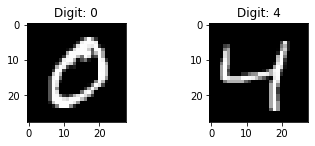

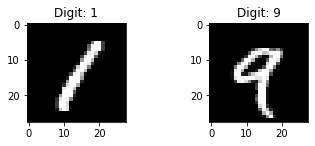

In [5]:
# Sanity check on data
for i in range(1,5,2):
  fig = plt.figure()
  
  ax1 = fig.add_subplot(2,2,i)
  ax2 = fig.add_subplot(2,2,i+1)
  ax1.imshow(dataset[i], cmap='gray')
  ax2.imshow(dataset[i+1], cmap='gray')
  
  ax1.set_title("Digit: %s" % labels[i])
  ax2.set_title("Digit: %s" % labels[i+1])
  plt.show()

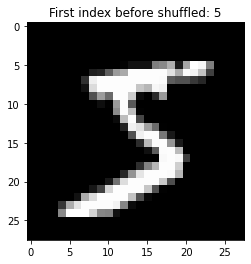

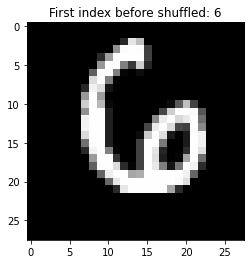

In [6]:
# Shuffle the train data
plt.imshow(x_train[0], cmap='gray')
plt.title("First index before shuffled: %s" % y_train[0])
plt.show()

x_train, y_train = utils.shuffle(x_train, y_train, random_state=21)
plt.imshow(x_train[0], cmap='gray')
plt.title("First index before shuffled: %s" % y_train[0])
plt.show()

In [7]:
print("Proxy train dataset contains %s images and %s labels" % (len(x_train), len(y_train)))

Proxy train dataset contains 60000 images and 60000 labels


In [8]:
# Partitioned proxy data to clients, each receiving 600 examples
N_CLIENTS = 100
clients_data = {}
clients_label = {}

# Distribute the data to all clients
i=1
for data in np.array_split(x_train, N_CLIENTS):
  clients_data["client_%s" % i] = data
  i+=1

i=1
for label in np.array_split(y_train, N_CLIENTS):
  clients_label["client_%s" % i] = label
  i+=1

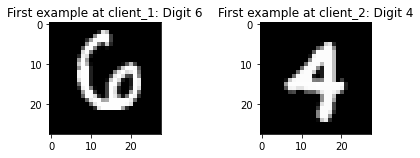

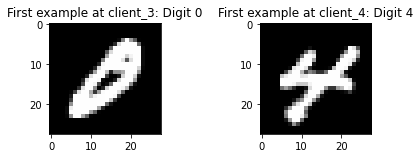

In [9]:
# Sanity check on clients data
for i in range(1,5,2):
  fig = plt.figure()
  
  ax1 = fig.add_subplot(2,2,i)
  ax2 = fig.add_subplot(2,2,i+1)
  ax1.imshow(clients_data['client_%s' % i][0], cmap='gray')
  ax2.imshow(clients_data['client_%s' % (i+1)][0], cmap='gray')
  
  ax1.set_title("First example at client_%s: Digit %s" % (i, clients_label['client_%s' % i][0]))
  ax2.set_title("First example at client_%s: Digit %s" % (i+1, clients_label['client_%s' % (i+1)][0]))
  
  plt.tight_layout()
  plt.show()

In [10]:
# Scale image to [0,1]
for key, value in clients_data.items():
  clients_data[key] = value / 255.0

In [11]:
# Global model: 2NN
class NN2Layers:
  def initiate(self, n_classes):
    model = Sequential([
                        Flatten(input_shape=(28,28)), 
                        Dense(200, activation='relu'), 
                        Dense(200, activation='relu'), 
                        Dense(n_classes, activation='softmax')
    ])

    return model

In [12]:
# Scaling weights to the dataset proportion
def scale_weights(num_local_samples, weights, chosen_clients):
  num_total_samples = len(chosen_clients) * num_local_samples
  scaling_factor = num_local_samples / num_total_samples

  # Loop through each layer weight & biases
  scaled_weights = []
  for component in weights:
    scaled_weights.append(scaling_factor * component)

  return scaled_weights

# Sum all the scaled weights from all clients
def sum_scaled_weights(scaled_weights):
  final_weights = []
  for component in zip(*scaled_weights):
    final_weights.append(tf.math.reduce_sum(component, axis=0))
  
  return final_weights

# Custom global model evaluation
def evaluate_model(model, test_data, test_label):
  y_pred = model.predict(test_data)
  y_true = test_label

  # Calculate loss with SCCE
  scce = tf.keras.losses.SparseCategoricalCrossentropy()
  loss = scce(y_true, y_pred).numpy()

  # Calculate accuracy
  accuracy = accuracy_score(y_true, np.argmax(y_pred, axis=1))

  return round(loss, 4), round(accuracy, 4)

In [ ]:
# CLIENT_FRACTIONS = [0.0, 0.1] # Client fractions, 0 means exactly 1 client
CLIENT_FRACTIONS = [0.1] # Client fractions, 0 means exactly 1 client
BATCH_SIZES = ["all"] # Batch sizes, 'all' means all local dataset treated as one batch

history = []
for c_fraction in CLIENT_FRACTIONS:
  for b_size in BATCH_SIZES:
    # Initiate the global 2NN model
    nn = NN2Layers()
    global_nn = nn.initiate(10) 
    recorded_test_accuracy = 0
    comm_round = 1
    estimated_comm_round = 1000
    start_time = time()

#     while (recorded_test_accuracy < 0.97): # Stop the loop when it reaches 97% of test-accuracy
    for i in tqdm(range(estimated_comm_round)):

      # Save the global weight
      global_weights = global_nn.get_weights()
      
      # Take c random subset client
      if c_fraction == 0.0:
        chosen_clients = np.random.choice(list(clients_data.keys()), 1)
      else:
        chosen_clients = np.random.choice(list(clients_data.keys()), \
                                          int(c_fraction*len(clients_data)))
      
      clients_weight = [] 
      for client in chosen_clients:
        # Iniatiate local model
        optimizer = tf.keras.optimizers.SGD(
            learning_rate=0.2)
        nn = NN2Layers()
        local_nn = nn.initiate(10)
        local_nn.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
            )

        # Set global weight to the local model
        local_nn.set_weights(global_weights)

        # Do training on local
        b_size = len(clients_data[client]) if b_size == "all" else b_size
        local_nn.fit(clients_data[client], clients_label[client], batch_size=b_size, epochs=1, verbose=0)
        
        # Save weight
        scaled_weights = scale_weights(len(clients_data[client]), local_nn.get_weights(), chosen_clients) # 1st algo: scaled weight
        clients_weight.append(scaled_weights)

      # Sum all scaled weights & update the global model
      global_nn.set_weights(sum_scaled_weights(clients_weight)) # 1st algo: sum scaled weight

      # Evaluate the loss & accuracy
      train_loss, train_accuracy = evaluate_model(global_nn, x_train, y_train)
      test_loss, test_accuracy = evaluate_model(global_nn, x_test, y_test)

      # Save metrics for current round
      data = {"C": c_fraction, "B": b_size, "comm_round": comm_round, "train_acc": train_accuracy, 
              "test_acc": test_accuracy, "train_loss": train_loss, "test_loss": test_loss}
      history.append(data)
      print(data)
      global_nn.save("b_600_c_0.1")

      # Update variables
      recorded_test_accuracy = test_accuracy
      comm_round += 1
    end_time = time()
    print("Took %.2f seconds." % (end_time - start_time))

  0%|          | 0/1000 [00:00<?, ?it/s]

###### Setup: Non-IID Setting & 2NN

In [ ]:
# MNIST Data from Tensorflow
# Splitted into train, test by default, we could re-arrange later on
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
# Join the dataset & labels as whole
dataset = np.concatenate((x_train, x_test), axis=0)
labels = np.concatenate((y_train, y_test), axis=0)

print("Dataset contains %s images and %s labels" % (dataset.shape[0], labels.shape[0]))

In [ ]:
# Sanity check on data
for i in range(1,5,2):
  fig = plt.figure()
  
  ax1 = fig.add_subplot(2,2,i)
  ax2 = fig.add_subplot(2,2,i+1)
  ax1.imshow(dataset[i], cmap='gray')
  ax2.imshow(dataset[i+1], cmap='gray')
  
  ax1.set_title("Digit: %s" % labels[i])
  ax2.set_title("Digit: %s" % labels[i+1])
  plt.show()

In [ ]:
# Sort the train data based on digits label
sorted_index = np.argsort(y_train)
